# Prey predator braitenberg notebook

This notebook showcases how to add new features on top on a pre-existing vivarium environment. Here, we will focus on implementing a prey predator braitenberg environment.

## Imports

Start by import standard jax functions as well as elements (Classes, functions ...) from the environment you want to build features on.

In [1]:
from enum import Enum
from functools import partial
from typing import Tuple

import jax.numpy as jnp

from jax import vmap, jit
from flax import struct

from vivarium.experimental.environments.braitenberg.simple import BraitenbergEnv, AgentState, State, EntityType
from vivarium.experimental.environments.braitenberg.simple import sensorimotor, compute_prox, behavior_name_map

2024-06-17 16:55:41.332298: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Define the states classes of prey predator env 

Redefine the classes and constants of the environment (most of them inherit from the simple braitenbeg one). We will just add a new field agent_type (prey or predator) for all of our agents.

In [2]:

class AgentType(Enum):
    PREY = 0
    PREDATOR = 1

@struct.dataclass
class AgentState(AgentState):
    agent_type: jnp.array

### Define prey predator env class 

Our environment inherits from the simple Braitenberg env, so we will only have to overwrite a few methods and create some new ones to create our prey predator environment. 

First, we need to overwrite the \_\_init__() function to allow specifying new parameters about preys and predators (their number and their colors here).

Then, we also have to overwrite the _init_agents() function because we have a new AgentState class. We also add a small modification to  init_state() to add indexes of prey and predators agents as attributes of the class.

Finally, we just have to write functions to implement our new desired features (here the predators will kill the preys next to them), and add them in the _step() function !

In [3]:
class PreyPredBraitenbergEnv(BraitenbergEnv):
    def __init__(
            self,
            # New prey_predators args, should maybe add warnings to avoid incompatible values (e.g less agents than prey + pred)
            n_preys=25,
            n_predators=25,
            pred_eating_range=10,
            prey_color=jnp.array([0.0, 0.0, 1.0]),
            predator_color=jnp.array([1.0, 0.0, 0.0]),
            **kwargs
    ):  
        # Initialize the attributes of old class with max_agents = n_preys + n_predators
        max_agents = n_preys + n_predators  
        super().__init__(max_agents=max_agents, **kwargs)
        # Add specific attributes about prey / predator environment
        self.n_preys = n_preys
        self.n_predators = n_predators
        self.prey_color = prey_color
        self.predator_color = predator_color
        self.pred_eating_range = pred_eating_range

    def _init_agents(self):
        # Added agent types for prey and predators
        agent_types = jnp.hstack((jnp.full(self.n_preys, AgentType.PREY.value), jnp.full(self.n_predators, AgentType.PREDATOR.value)))
        agents_colors = jnp.concatenate((jnp.tile(self.prey_color, (self.n_preys, 1)), jnp.tile(self.predator_color, (self.n_predators, 1))), axis=0)
        behaviors = jnp.hstack((jnp.full(self.n_preys, behavior_name_map['FEAR']), jnp.full(self.n_predators, behavior_name_map['AGGRESSION'])))

        agents = AgentState(
            # idx in the entities (ent_idx) state to map agents information in the different data structures
            ent_idx=jnp.arange(self.max_agents, dtype=int),
            agent_type=agent_types, 
            prox=jnp.zeros((self.max_agents, 2)),
            motor=jnp.zeros((self.max_agents, 2)),
            behavior=behaviors,
            wheel_diameter=jnp.full((self.max_agents), self.wheel_diameter),
            speed_mul=jnp.full((self.max_agents), self.speed_mul),
            max_speed=jnp.full((self.max_agents), self.max_speed),
            theta_mul=jnp.full((self.max_agents), self.theta_mul),
            proxs_dist_max=jnp.full((self.max_agents), self.prox_dist_max),
            proxs_cos_min=jnp.full((self.max_agents), self.prox_cos_min),
            proximity_map_dist=jnp.zeros((self.max_agents, 1)),
            proximity_map_theta=jnp.zeros((self.max_agents, 1)),
            color=agents_colors
            )

        return agents

    def init_state(self) -> State:
        state = super().init_state()

        # Add idx utils to simplify conversions between entities and agent states
        self.agents_idx = jnp.where(state.entities.entity_type == EntityType.AGENT.value)
        self.prey_idx = jnp.where(state.agents.agent_type == AgentType.PREY.value)
        self.pred_idx = jnp.where(state.agents.agent_type == AgentType.PREDATOR.value)

        return state
    
    # Add a function to detect if a prey will be eaten by a predator in the current step
    def can_all_be_eaten(self, R_prey, R_predators, predator_exist):
        # Could maybe create this as a method in the class, or above idk
        distance_to_all_preds = vmap(self.distance, in_axes=(None, 0))

        # Same for this, the only pb is that the fn above needs the displacement arg, so can't define it in the cell above 
        def can_be_eaten(R_prey, R_predators, predator_exist):
            dist_to_preds = distance_to_all_preds(R_prey, R_predators)
            in_range = jnp.where(dist_to_preds < self.pred_eating_range, 1, 0)
            # Could also return which agent ate the other one (e.g to increase their energy) 
            will_be_eaten_by = in_range * predator_exist
            eaten_or_not = jnp.where(jnp.sum(will_be_eaten_by) > 0., 1, 0)
            return eaten_or_not
        
        can_be_eaten = vmap(can_be_eaten, in_axes=(0, None, None))
        
        return can_be_eaten(R_prey, R_predators, predator_exist)
    
    # Add functions so predators eat preys
    def eat_preys(self, state):
        # See which preys can be eaten by predators and update the exists array accordingly
        R = state.entities.position.center
        exist = state.entities.exists
        prey_idx = self.prey_idx
        pred_idx = self.pred_idx

        agents_ent_idx = state.agents.ent_idx
        predator_exist = exist[agents_ent_idx][pred_idx]
        can_be_eaten_idx = self.can_all_be_eaten(R[prey_idx], R[pred_idx], predator_exist)

        # Kill the agents that are being eaten
        exist_prey = exist[agents_ent_idx[prey_idx]]
        new_exists_prey = jnp.where(can_be_eaten_idx == 1, 0, exist_prey)
        exist = exist.at[agents_ent_idx[prey_idx]].set(new_exists_prey)

        return exist

    # Add the eat_preys function in the _step loop
    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors: jnp.array, agents_neighs_idx: jnp.array) -> Tuple[State, jnp.array]:
        # 1 Compute which agents are being eaten
        exist = self.eat_preys(state)
        entities = state.entities.replace(exists=exist)

        # 2 Compute the proximeter of agents
        exists_mask = jnp.where(entities.exists == 1, 1, 0)
        prox, proximity_dist_map, proximity_dist_theta = compute_prox(state, agents_neighs_idx, target_exists_mask=exists_mask, displacement=self.displacement)
        motor = sensorimotor(prox, state.agents.behavior, state.agents.motor)
        agents = state.agents.replace(
            prox=prox, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=motor
        )

        # 3 Update the state with the new agent and entities states
        state = state.replace(
            agents=agents,
            entities=entities
        )

        # 4 Apply physics forces to the environment state
        entities = self.apply_physics(state, neighbors)
        state = state.replace(
            time=state.time+1,
            entities=entities,
        )

        # 5 Update the neighbors according to the new positions
        neighbors = neighbors.update(state.entities.position.center)
        return state, neighbors

### Create env and render its state

We define the colors in our environment this way: 

- Prey agents: blue
- Predator agents: red
- Objects: green

In [4]:
from vivarium.experimental.environments.braitenberg.render import render, render_history

In [5]:
BOX_SIZE = 200

N_PRED = 25
N_PREY = 25
MAX_OBJ = 25

PRED_COLOR = jnp.array([1., 0., 0.])
PREY_COLOR = jnp.array([0., 0., 1.])
OBJ_COLOR = jnp.array([0., 1., 0.])

env = PreyPredBraitenbergEnv(
    box_size=BOX_SIZE,
    max_objects=MAX_OBJ,
    predator_color=PRED_COLOR,
    prey_color=PREY_COLOR,
    objects_color=OBJ_COLOR,
    n_predators=N_PRED,
    n_preys=N_PREY
)
state = env.init_state()

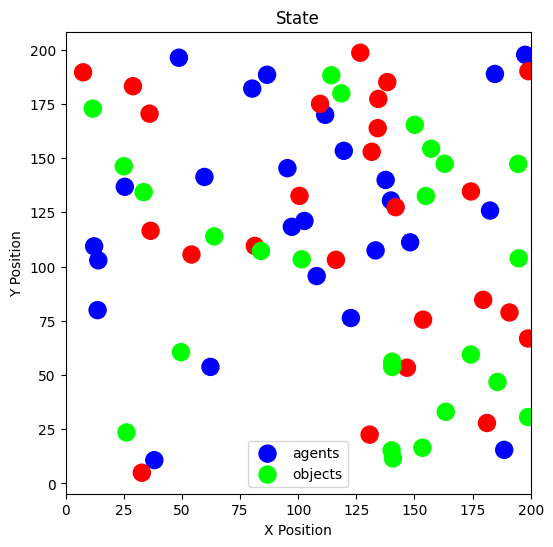

In [6]:
render(state)

### Run a simulation on a few timesteps

In [7]:
n_steps = 2000

hist = []
for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

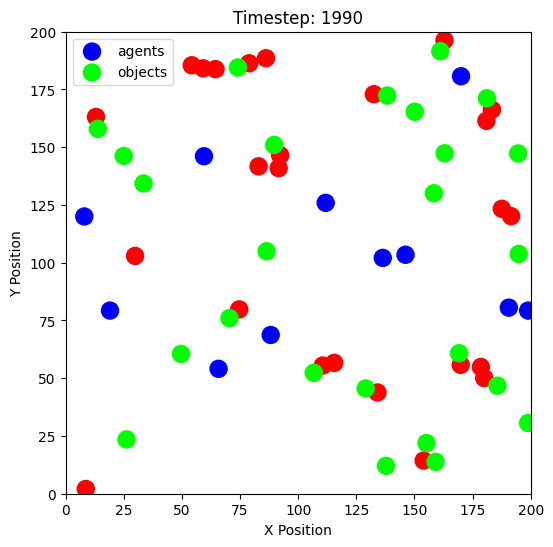

In [8]:
render_history(hist, skip_frames=10)

The rendering function is quite laggy, but we can see that prey agents are now being eaten by predator ones ! 